In [1]:
import sqlite3, pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
# Connect to SQLite database
DB_PATH = "/home/daniel/Downloads/reviews_sample.db"
conn = sqlite3.connect(DB_PATH)

print(f"Connected to {DB_PATH}")


Connected to /home/daniel/Downloads/reviews_sample.db


In [3]:
# Quick check: available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print("Available tables:")
print(tables)

Available tables:
              name
0  sqlite_sequence
1          authors
2           hotels
3          reviews


In [4]:
pd.read_sql("""select * from authors limit 1""", conn)

,auhtor_no,author_id,author_name,author_location,author_num_reviews,author_num_cities,author_num_helpful_votes,author_num_type_reviews
0,1,8C0B42FF3C0FA366A21CFD785302A032,Papa_Panda,Gold Coast,29,22,12,24


In [5]:
pd.read_sql("""select * from hotels limit 1""", conn)

,offering_id
0,72572


In [6]:
pd.read_sql("""select * from reviews limit 1""", conn)

,id,author_no,author_id,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,via_mobile,author_num_helpful_votes
0,11676795,None,1BC33D747AFD41207DDF1B30389F2D06,93466,5.0,4.0,4.0,3.0,4.0,None,4.0,“It was great!”,At check in the staff were very nice and offer...,2007-12-25 00:00:00,December 2007,0,10


In [7]:
df = pd.read_sql("""select * from reviews""", conn)
df.head()

,id,author_no,author_id,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,via_mobile,author_num_helpful_votes
0,11676795,None,1BC33D747AFD41207DDF1B30389F2D06,93466,5.0,4.0,4.0,3.0,4.0,NaN,4.0,“It was great!”,At check in the staff were very nice and offer...,2007-12-25 00:00:00,December 2007,0,10.0
1,11703779,None,2E16868E5A8347E563556F0691E0CF20,83489,1.0,1.0,3.0,1.0,3.0,NaN,2.0,“I wouldn't recommend this one...”,A friend and I stayed at this hotel for a rece...,2007-12-20 00:00:00,December 2007,0,1.0
2,11704360,None,6A157001884A4B2AB61F56F785F8B3F9,119601,5.0,5.0,5.0,5.0,5.0,NaN,5.0,“So Quiet! So Friendly!”,"Our stay was so quiet, we were very surprised!...",2007-12-20 00:00:00,November 2007,0,3.0
3,11705348,None,E8754ED06F958B342C00B1AD33884360,126257,3.0,3.0,4.0,5.0,5.0,NaN,2.0,“Great location - decent BUDGET hotel”,The location is superb. \nJust a few blocks aw...,2007-12-20 00:00:00,December 2007,0,35.0
4,11705477,None,8445910D017299B5414EF873A2E4ED57,99365,1.0,NaN,NaN,NaN,NaN,NaN,NaN,“Housekeepers steal!”,Do not stay at this hotel!!! I had my ipod sto...,2007-12-20 00:00:00,December 2007,0,1.0


In [8]:
# check the date range, we don't need to filter 
# by date since requirement is 5 years
print(df["review_date"].min(), df["review_date"].max())

2007-12-20 00:00:00 2012-12-20 00:00:00


In [9]:
print(len(df))

754798


### Filtering of dataframe

This section will reduce the dataframe to 50-80k rows as per requirements. 

We start by performing basic cleaning to remove NA rows and remove duplicates. 

We next want to retain only the reviews which are considered the most helpful. This is done by taking the top X percentile of reviews from the dataset based on the `author_num_helpful_votes` attribute.

In [10]:
# start by selecting columns that will be used in this assignment
df = df[["offering_id", "overall", "service", "cleanliness", "value", "location_rating",
         "sleep_quality", "rooms", "title", "text", "review_date", "date_stayed", "author_num_helpful_votes"]]
df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
0,93466,5.0,4.0,4.0,3.0,4.0,NaN,4.0,“It was great!”,At check in the staff were very nice and offer...,2007-12-25 00:00:00,December 2007,10.0
1,83489,1.0,1.0,3.0,1.0,3.0,NaN,2.0,“I wouldn't recommend this one...”,A friend and I stayed at this hotel for a rece...,2007-12-20 00:00:00,December 2007,1.0
2,119601,5.0,5.0,5.0,5.0,5.0,NaN,5.0,“So Quiet! So Friendly!”,"Our stay was so quiet, we were very surprised!...",2007-12-20 00:00:00,November 2007,3.0
3,126257,3.0,3.0,4.0,5.0,5.0,NaN,2.0,“Great location - decent BUDGET hotel”,The location is superb. \nJust a few blocks aw...,2007-12-20 00:00:00,December 2007,35.0
4,99365,1.0,NaN,NaN,NaN,NaN,NaN,NaN,“Housekeepers steal!”,Do not stay at this hotel!!! I had my ipod sto...,2007-12-20 00:00:00,December 2007,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754793,115754,4.0,3.0,4.0,4.0,4.0,NaN,5.0,“全套房酒店”,这家是全套房酒店，因此每件房间都会有起居室和卧室，适合常住的商务客。酒店离西雅图的购物区比较...,2012-12-18 00:00:00,common_month_year0,NaN
754794,124186,2.0,1.0,1.0,4.0,1.0,NaN,1.0,“Horrid”,Sheets had six stains on them. Floors were dir...,2012-12-20 00:00:00,December 2012,1.0
754795,111441,4.0,4.0,5.0,4.0,5.0,5.0,5.0,“Great Location in Downtown Boston”,Visited Boston on Dec 16-17 and stay at Hyatt ...,2012-12-20 00:00:00,December 2012,20.0
754796,112132,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“Fabulous hotel and even better customer servi...,"Even though I live in the city, I surprised my...",2012-12-20 00:00:00,December 2012,NaN


In [11]:
# since requirement is 50-80k rows when the dataset is 750k rows, we can afford to be picky here
# only retain rows that are populated for all our columns
df = df.dropna()
df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147732,93470,1.0,1.0,1.0,1.0,3.0,1.0,1.0,"“Noisy, bug bites, poor furnishings, tiny”",I have traveled for business and stayed at the...,2010-02-01 00:00:00,November 2009,1.0
147733,94326,4.0,5.0,5.0,4.0,4.0,4.0,4.0,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.0
147734,93352,5.0,5.0,5.0,4.0,5.0,5.0,5.0,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.0
147735,93358,2.0,1.0,1.0,3.0,5.0,1.0,1.0,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.0
147737,84113,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754783,84137,4.0,4.0,4.0,5.0,5.0,5.0,3.0,“Excellent location”,Location: The location was very good as it was...,2012-12-20 00:00:00,August 2012,11.0
754784,120056,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“A Kimpton Classic”,The Monaco in Denver epitomizes the Kimpton ae...,2012-12-20 00:00:00,December 2012,10.0
754791,94330,4.0,4.0,4.0,3.0,4.0,4.0,4.0,"“Nice area, and stay”",I stayed at the Seaport for a night as our com...,2012-12-20 00:00:00,December 2012,5.0
754795,111441,4.0,4.0,5.0,4.0,5.0,5.0,5.0,“Great Location in Downtown Boston”,Visited Boston on Dec 16-17 and stay at Hyatt ...,2012-12-20 00:00:00,December 2012,20.0


In [13]:
# since we plan to eventually model the text column for potential 
# granular improvements in the next assignment, 
# drop any rows with duplicated text
df = df.drop_duplicates(subset=['text'])
df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147732,93470,1.0,1.0,1.0,1.0,3.0,1.0,1.0,"“Noisy, bug bites, poor furnishings, tiny”",I have traveled for business and stayed at the...,2010-02-01 00:00:00,November 2009,1.0
147733,94326,4.0,5.0,5.0,4.0,4.0,4.0,4.0,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.0
147734,93352,5.0,5.0,5.0,4.0,5.0,5.0,5.0,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.0
147735,93358,2.0,1.0,1.0,3.0,5.0,1.0,1.0,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.0
147737,84113,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754783,84137,4.0,4.0,4.0,5.0,5.0,5.0,3.0,“Excellent location”,Location: The location was very good as it was...,2012-12-20 00:00:00,August 2012,11.0
754784,120056,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“A Kimpton Classic”,The Monaco in Denver epitomizes the Kimpton ae...,2012-12-20 00:00:00,December 2012,10.0
754791,94330,4.0,4.0,4.0,3.0,4.0,4.0,4.0,"“Nice area, and stay”",I stayed at the Seaport for a night as our com...,2012-12-20 00:00:00,December 2012,5.0
754795,111441,4.0,4.0,5.0,4.0,5.0,5.0,5.0,“Great Location in Downtown Boston”,Visited Boston on Dec 16-17 and stay at Hyatt ...,2012-12-20 00:00:00,December 2012,20.0


In [14]:
# we then filter the dataset based on the `author_num_helpful_votes`
# attribute at various percentiles to determine an ideal threshold 
for q in range(50, 100, 5):
  threshold = df['author_num_helpful_votes'].quantile(q/100)
  print(f"Percentile: {q}, threshold: {threshold},", "num of rows: ", len(df[df['author_num_helpful_votes'] >= threshold]))

Percentile: 50, threshold: 7.0, num of rows:  181737
Percentile: 55, threshold: 9.0, num of rows:  156103
Percentile: 60, threshold: 10.0, num of rows:  144946
Percentile: 65, threshold: 12.0, num of rows:  126416
Percentile: 70, threshold: 15.0, num of rows:  104526
Percentile: 75, threshold: 18.0, num of rows:  87607
Percentile: 80, threshold: 22.0, num of rows:  71100
Percentile: 85, threshold: 28.0, num of rows:  53163
Percentile: 90, threshold: 38.0, num of rows:  35219
Percentile: 95, threshold: 61.0, num of rows:  17334


In [15]:
# for this assignment, we will go with 80 percentile
# to capture the most number of data points
df = df[df['author_num_helpful_votes'] >= 22]
df

,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147733,94326,4.0,5.0,5.0,4.0,4.0,4.0,4.0,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.0
147734,93352,5.0,5.0,5.0,4.0,5.0,5.0,5.0,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.0
147735,93358,2.0,1.0,1.0,3.0,5.0,1.0,1.0,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.0
147737,84113,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.0
147739,502408,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“Should have stuck to here all along!”,"I've stayed at this hotel twice now, once year...",2010-02-01 00:00:00,January 2010,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754734,1762915,4.0,5.0,5.0,3.0,5.0,4.0,4.0,“Expectations Met”,My husband and I booked a room impromptu and s...,2012-12-19 00:00:00,December 2012,27.0
754739,3523356,4.0,5.0,5.0,5.0,5.0,5.0,5.0,“A Four-star hotel at a Two-star price....wort...,I've stayed at plenty of Hampton Inns during m...,2012-12-19 00:00:00,December 2012,27.0
754744,321151,4.0,5.0,4.0,5.0,5.0,4.0,4.0,“Stay here. Here's why:”,"Ok, first of all, The Back Bay Hotel is part o...",2012-12-19 00:00:00,December 2012,132.0
754745,1027237,2.0,3.0,3.0,3.0,5.0,3.0,3.0,“Nothing special but beware of the downstairs ...,The king room was ok. Clean with comfortable b...,2012-12-19 00:00:00,December 2012,26.0


### Validation checks

This section will perform validation checks on the data to ensure that
they are within the expected boundaries.

We also check the dataframe with the next assignment in mind by filtering out any reviews text that are less than 1 sentence long to retain more meaningful reviews.

Checks include:
- `rating columns` must be between 1-5
- `text` column should not be empty or very short (less than 100 characters)

In [16]:
# check that rating columns are between 1-5
rating_cols = ['overall', 'service', 'cleanliness', 'value', 'location_rating', 'sleep_quality', 'rooms']

# check if any ratings fall outside the 1-5 range
out_of_range = df[~df[rating_cols].isin(range(1, 6)).all(axis=1)]

# get average of each rating to spot anomalies
df[rating_cols].describe().loc[['min', 'max', 'mean']]

,overall,service,cleanliness,value,location_rating,sleep_quality,rooms
min,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
max,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000
mean,3.982166,4.120394,4.28398,3.888622,4.414304,4.077004,3.955907


In [17]:
# Check for empty titles or very short reviews (less than 100 characters)
# we want to filter out review less than 1 sentence long so we have more
# information to model areas of improvements
short_reviews = df[df['text'].str.len() < 100]

print(f"rows with short reviews: {len(short_reviews)}")

df = df[df['text'].str.len() >= 100]
df

rows with short reviews: 270


,offering_id,overall,service,cleanliness,value,location_rating,sleep_quality,rooms,title,text,review_date,date_stayed,author_num_helpful_votes
147733,94326,4.0,5.0,5.0,4.0,4.0,4.0,4.0,“Nice find in Boston”,"After reading past reviews, I wasn't quite sur...",2010-02-01 00:00:00,January 2010,88.0
147734,93352,5.0,5.0,5.0,4.0,5.0,5.0,5.0,“BEST”,Great location and I was wondering if I would ...,2010-02-01 00:00:00,October 2009,25.0
147735,93358,2.0,1.0,1.0,3.0,5.0,1.0,1.0,“Not what we really expected”,I'd found out about this hotel ages before boo...,2010-02-01 00:00:00,January 2010,25.0
147737,84113,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“Above and Beyond what you'd normally expect”,Right away we were impressed with this hotel. ...,2010-02-01 00:00:00,January 2010,31.0
147739,502408,5.0,5.0,5.0,5.0,5.0,5.0,5.0,“Should have stuck to here all along!”,"I've stayed at this hotel twice now, once year...",2010-02-01 00:00:00,January 2010,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
754734,1762915,4.0,5.0,5.0,3.0,5.0,4.0,4.0,“Expectations Met”,My husband and I booked a room impromptu and s...,2012-12-19 00:00:00,December 2012,27.0
754739,3523356,4.0,5.0,5.0,5.0,5.0,5.0,5.0,“A Four-star hotel at a Two-star price....wort...,I've stayed at plenty of Hampton Inns during m...,2012-12-19 00:00:00,December 2012,27.0
754744,321151,4.0,5.0,4.0,5.0,5.0,4.0,4.0,“Stay here. Here's why:”,"Ok, first of all, The Back Bay Hotel is part o...",2012-12-19 00:00:00,December 2012,132.0
754745,1027237,2.0,3.0,3.0,3.0,5.0,3.0,3.0,“Nothing special but beware of the downstairs ...,The king room was ok. Clean with comfortable b...,2012-12-19 00:00:00,December 2012,26.0


### Competitive Benchmarking

We believe different demographics book hotels based on different priorities. Some may prefer a better location, while others might want better service etc.

Instead of using industry labels, we group the hotels based on the 6 rating categories to provide a similar overall "experience profile" to holistically evaluate the hotel:
- service
- cleanliness
- value
- location_rating
- sleep_quality
- rooms

We then use KMEANS on the 6 rating categories to account for different trade offs between hotels that still deliver the same overall "experience" (e.g. a hotel might have lower "value" scores but perfect "service" and "rooms", vice versa)

We determine the ideal number of clusters using the elbow method and silhouette score.


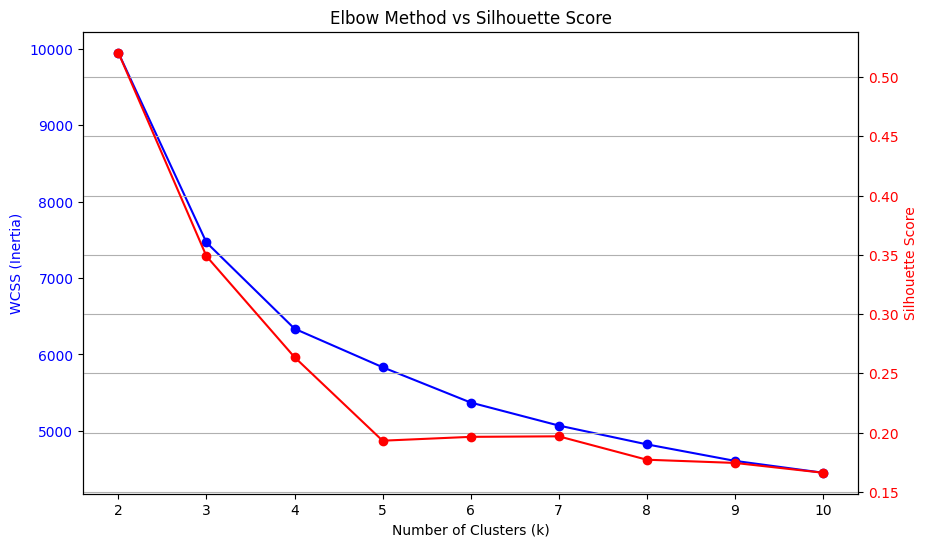

In [18]:
hotel_profiles = df.groupby('offering_id')[['service', 'cleanliness', 'value',
                                            'location_rating', 'sleep_quality', 'rooms']].mean()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(hotel_profiles)

# we find the best k using the elbow method/silhouette score
wcss = []
silhouette_avg = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    wcss.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(scaled_features, cluster_labels))

fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot WCSS on the left Y-axis
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color='blue')
ax1.plot(k_range, wcss, 'bo-', label='WCSS')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second Y-axis for the Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='red')
ax2.plot(k_range, silhouette_avg, 'ro-', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Elbow Method vs Silhouette Score')
plt.grid(True)
plt.show()

From visual inspection of the above plot, 3 or 4 clusters would appear to be a good fit.

To determine the right number of clusters to use, we plot the values of both clusters and use the following criteria:
- elbow method is used and silhouette score is ideally maximized
- values show an explanable segmentation of clients.

In [19]:
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
hotel_profiles['cluster'] = kmeans.fit_predict(scaled_features)

cluster_performance = hotel_profiles.groupby('cluster').mean()
print("Cluster Profiles (4 clusters):")
cluster_performance

Cluster Profiles (4 clusters):


,service,cleanliness,value,location_rating,sleep_quality,rooms
cluster,,,,,,
0,3.124480,3.116239,3.203658,3.516405,2.961702,2.819810
1,4.408680,4.545693,4.239328,4.436807,4.333221,4.291030
2,1.853116,1.653099,1.755865,2.588673,1.717787,1.490546
3,3.889582,3.997432,3.802779,4.036014,3.776818,3.627782


In [20]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
hotel_profiles['cluster'] = kmeans.fit_predict(scaled_features)

cluster_performance = hotel_profiles.groupby('cluster').mean()
print("Cluster Profiles (3 clusters):")
cluster_performance

Cluster Profiles (3 clusters):


,service,cleanliness,value,location_rating,sleep_quality,rooms
cluster,,,,,,
0,3.575554,3.629895,3.555049,3.807260,3.439738,3.289824
1,2.163587,2.015030,2.144766,2.817510,2.005053,1.789664
2,4.309194,4.447410,4.156824,4.365563,4.228047,4.160987


Since the silhouette score takes a sharp dive after 3 clusters, choosing 4 clusters may likely result in two segments that are too similar creating noise rather than distinct market segments. This is validated by the results from using 4 clusters above where clusters 1 and 3 appear to be roughly similar to each other in terms of being in the 4-4.5 region for most categories.

Choosing 3 clusters also has more busines utility where airlines generally price their offerings in 3 categories: Economy, Business, First Class. This pricing concept may have spillover effects on how people select their hotels.

The results from 3 clusters also offer a clearer interpretable segmentation:
- Cluster 0: The "Bang-for-Buck" Mid-Tier
  - These hotels score consistently in the mid-to-high 3s. They aren't winning awards, but they aren't failing either.

  - This is the "Practical Traveler" segment. These guests prioritize location (3.81) over luxury. They are willing to accept slightly dated rooms (3.29) as long as the hotel is in the right spot and the price is fair. It’s the "it's fine for a few nights" category.

- Cluster 1: The "Location Trap" (Budget/Convenience)
  - This cluster has the lowest scores across the board, specifically struggling with rooms (1.79) and cleanliness (2.01).

  - This is the "Functional/Distressed" segment. The only thing keeping this cluster alive is location (2.81), which is significantly higher than its other metrics. These guests likely choose these hotels because they are the only affordable option near a specific landmark or transit hub. They aren't happy, but they stay because of necessity.

- Cluster 2: The "Premium Experience" (Luxury/Elite)
  - These are the high-fliers, scoring 4.1 to 4.4 across every single metric.

  - This is the "Experience Seeker" or "Corporate Elite" segment. For these guests, cleanliness (4.44) and service (4.31) are non-negotiable. They are willing to pay a premium for consistency. This cluster represents brand loyalty and high expectations.

### Benchmarking for new hotels

New hotels may be interested to analyze their performance against their peers to determine how well (and badly) they are doing in each of the 6 rating categories (and by how much).

We hence create a method that takes in 6 rating categories and outputs how well (or badly) the hotel is doing with respect to its peers in the same category.

In [21]:
cluster_ids = {
    0: "Bang for Buck",
    1: "Location Trap",
    2: "Premium Experience"
}
def analyze_hotel_performance(service, cleanliness, value, location_rating, sleep_quality, rooms):
    ratings = [service, cleanliness, value, location_rating, sleep_quality, rooms]
    for rating in ratings:
        if rating < 1 or rating > 5:
            raise ValueError("Ratings have to be between 1-5 only.")
    ratings_scaled = scaler.transform([ratings])
    cluster_id = kmeans.predict(ratings_scaled)[0]
    print(f"Hotel belongs to '{cluster_ids[cluster_id]}' cluster.")
    print("Rating vs peers:")
    columns = cluster_performance.columns.tolist()
    peer_ratings = cluster_performance.loc[cluster_id].tolist()
    for column, peer_rating, hotel_rating in zip(columns, peer_ratings, ratings):
        pct_diff = ((hotel_rating - peer_rating) / peer_rating) * 100
        direction = "underperforming" if pct_diff < 0 else "outperforming"
        print(f"{column.upper()}: {direction.upper()} {pct_diff:.1f}% vs peers. (Avg: {peer_rating:.2f})")

In [22]:
ratings = [1,1,1,5,1,1] # good location but sub par everything else
analyze_hotel_performance(*ratings)

Hotel belongs to 'Location Trap' cluster.
Rating vs peers:
SERVICE: UNDERPERFORMING -53.8% vs peers. (Avg: 2.16)
CLEANLINESS: UNDERPERFORMING -50.4% vs peers. (Avg: 2.02)
VALUE: UNDERPERFORMING -53.4% vs peers. (Avg: 2.14)
LOCATION_RATING: OUTPERFORMING 77.5% vs peers. (Avg: 2.82)
SLEEP_QUALITY: UNDERPERFORMING -50.1% vs peers. (Avg: 2.01)
ROOMS: UNDERPERFORMING -44.1% vs peers. (Avg: 1.79)


/home/daniel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [23]:
ratings = [2,4,3,2,3,3] # bang for buck
analyze_hotel_performance(*ratings)

Hotel belongs to 'Bang for Buck' cluster.
Rating vs peers:
SERVICE: UNDERPERFORMING -44.1% vs peers. (Avg: 3.58)
CLEANLINESS: OUTPERFORMING 10.2% vs peers. (Avg: 3.63)
VALUE: UNDERPERFORMING -15.6% vs peers. (Avg: 3.56)
LOCATION_RATING: UNDERPERFORMING -47.5% vs peers. (Avg: 3.81)
SLEEP_QUALITY: UNDERPERFORMING -12.8% vs peers. (Avg: 3.44)
ROOMS: UNDERPERFORMING -8.8% vs peers. (Avg: 3.29)


/home/daniel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [24]:
ratings = [4,4,5,2,5,5] # premium
analyze_hotel_performance(*ratings)

Hotel belongs to 'Premium Experience' cluster.
Rating vs peers:
SERVICE: UNDERPERFORMING -7.2% vs peers. (Avg: 4.31)
CLEANLINESS: UNDERPERFORMING -10.1% vs peers. (Avg: 4.45)
VALUE: OUTPERFORMING 20.3% vs peers. (Avg: 4.16)
LOCATION_RATING: UNDERPERFORMING -54.2% vs peers. (Avg: 4.37)
SLEEP_QUALITY: OUTPERFORMING 18.3% vs peers. (Avg: 4.23)
ROOMS: OUTPERFORMING 20.2% vs peers. (Avg: 4.16)


/home/daniel/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
